In [1]:
from pathlib2 import Path
import requests

DATA_PATH = Path('data')
PATH = DATA_PATH/'mnist'

PATH.mkdir(parents=True, exist_ok=True)

URL = 'http://deeplearning.net/data/mnist/'
FILENAME = 'mnist.pkl.gz'

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open('wb').write(content)

In [2]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f)

(50000, 784)


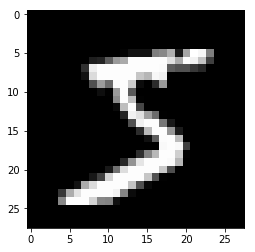

In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.imshow(x_train[0].reshape((28,28)), cmap="gray")
print(x_train.shape)

In [4]:
import torch

x_train, y_train, x_valid, y_valid = map(torch.tensor,(x_train, y_train, x_valid, y_valid))
n,c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5, 0, 4,  ..., 8, 4, 8]))
torch.Size([50000, 784])
(tensor(0), tensor(9))


In [5]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)
weights

tensor([[ 0.0144,  0.0148,  0.0286,  ..., -0.0320, -0.0625,  0.0340],
        [ 0.0333,  0.0182,  0.0111,  ..., -0.0032, -0.0069,  0.0288],
        [-0.0048,  0.0039,  0.0080,  ..., -0.0033,  0.0275,  0.0087],
        ...,
        [ 0.0029, -0.0327,  0.0038,  ..., -0.0217, -0.0512, -0.0058],
        [-0.0355, -0.0138,  0.0051,  ...,  0.0285, -0.0251, -0.0389],
        [ 0.0192, -0.0042,  0.0091,  ...,  0.0335, -0.0457,  0.0219]],
       requires_grad=True)

In [6]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    xb.transpose_(0,1)
    return log_softmax(xb*weights + bias)

In [7]:
bs = 1
xb = x_train[0:bs]
xb[0].shape
preds = model(xb)
preds[0], preds.shape
print(preds[0], preds.shape)

(tensor([-2.3026, -2.3026, -2.3026, -2.3026, -2.3026, -2.3026, -2.3026, -2.3026,
        -2.3026, -2.3026], grad_fn=<SelectBackward>), torch.Size([784, 10]))


In [8]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [9]:
yb = y_train[0:bs]
print(loss_func(preds,yb))

tensor(2.3026, grad_fn=<NegBackward>)


In [10]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [11]:
print(accuracy(preds,yb))

tensor(0.0153)


In [12]:
lr = 0.5
epochs = 2

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [13]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

RuntimeError: The size of tensor a (784) must match the size of tensor b (10) at non-singleton dimension 1

In [17]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return weights*xb + bias

In [18]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

RuntimeError: The size of tensor a (10) must match the size of tensor b (784) at non-singleton dimension 1

In [31]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super(Mnist_Logistic,self).__init__()
        self.weights = nn.Parameter(torch.randn(784,10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
    
    def forward(self,xb):
        return xb * self.weights + self.bias

In [32]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

RuntimeError: The size of tensor a (784) must match the size of tensor b (10) at non-singleton dimension 1

In [26]:
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()

AttributeError: 'function' object has no attribute 'parameters'

In [34]:
from caffe2.python import workspace, model_helper